# Working with ICESat-2 Sea Ice Products

## Overview

In this notebook, we demonstrate searching for and accessing ICESat-2 data using the Python `earthaccess` package, and reading and visualizing the data using `xarray` and `pandas`.  We also use `matplotlib` and `cartopy` to produce a map of search results. 

`earthaccess` is a community developed open source Python package to streamline programmatic search and access for NASA data archives.  Users can find data sets and data granules, and either download or "stream" NASA data in as little as three "lines of code", regardless of whether users are working in the cloud or on a local machine.  The `earthaccess` package handles authentication for NASA Earthdata Login and the AWS hosted NASA Earthdata cloud.  All you need is an Earthdata Login.

`xarray` has become the go to Python package for Earth Data Science.  With v2024.10.0, `xarray` can be used to read and work with data stored hiearchical file structures like the HDF5 file format used for ICESat-2, using the [`DataTree`](https://xarray.dev/blog/datatree) structure.  We use [`xarray.DataTree`](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html#xarray.DataTree) to read and explore ICESat-2 files.

Although `xarray` could be used to work with the ICESat-2 data, the nested-group structure can be a little cumbersome.  So we create a `pandas.DataFrame` object for a subset of data to make plotting easier.



## Import libraries

As with all Python, we import the libraries we will use.

In [1]:
# Search for data
import earthaccess

# Read and work with data
import xarray as xr
import pandas as pd

# To plot results
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# To plot map of results
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Check package versions: you may want to update if you have older versions
# See README.md
print(f"earthaccess: {earthaccess.__version__}")
print(f"xarray: {xr.__version__}")
print(f"cartopy: {cartopy.__version__}")

/home/apbarret/mambaforge/envs/nsidc-tutorials-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


earthaccess: 0.14.0
xarray: 2025.7.1
cartopy: 0.24.0


## Authenticate

Although you do not need an Earthdata login to search for NASA data, you do need one to access that data.  It is better just to login at the start of a workflow so you don't forget.

You will need an Earthdata login.  If you don't have one, you can register for one, for free, [here](https://urs.earthdata.nasa.gov/users/new).

`earthaccess` will prompt for your Earthdata login username and password.  You can also set up a `.netrc` file or environment variables.  `earthaccess` will search for these alternatives before prompting for a username and login.  See the `earthaccess` [documentation](https://earthaccess.readthedocs.io/en/latest/user_guide/authenticate/) to lean how to do this.

In [2]:
auth = earthaccess.login()

## Search for ICESat-2 Related Datasets

Before we search for data, we want to know what ICESat-2 datasets and what versions of these datasets are available.  We will also need to know the `short-name` or `concept-id` of the ICESat-2 dataset we want to use.

The `short-name` can be found on the dataset landing pages for products or we can search for it.

To search for datasets (or Collections as NASA calls them), we use the `search_datasets` method.  This allows searches by keywords, platform, time range, spatial extent, version, and whether data are hosted in the cloud or still archived at a NASA DAAC.

Here, we will do a simple search using `platform` for ICESat-2 data.  The `platform` and `keyword` searches are not case sensitive.  We'll add `downloadable=True` and `cloud_hosted=True` to further refine the search.

In [3]:
results = earthaccess.search_datasets(
    platform="icesat-2",
    downloadable=True,
    cloud_hosted=True,
)

`search_datasets` returns a Python List of data collections.  We can find how many datasets were found by getting the length of that list using `len`.

In [4]:
len(results)

47

There are 47 datasets.  Because `results` is a list, we can access any element of that list by giving an index.  Here, we'll access the first element (`0`).  Just change the index to see a different dataset. 

Each data collection has a `summary` method that returns a Python dictionary containing `short-name`, `concept-id`, and `version`, along with information about the file type and links to get the data.  The file links are used by earthaccess, so we don't need to worry about these too much.

In [5]:
results[0].summary()

{'short-name': 'ATL03',
 'concept-id': 'C2596864127-NSIDC_CPRD',
 'version': '006',
 'file-type': "[{'FormatType': 'Native', 'Format': 'HDF5', 'FormatDescription': 'HTTPS'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search/granules?p=C2596864127-NSIDC_CPRD',
  'https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2596864127-NSIDC_CPRD',
  'https://nsidc.org/data/data-access-tool/ATL03/versions/6/'],
 'cloud-info': {'Region': 'us-west-2',
  'S3BucketAndObjectPrefixNames': ['nsidc-cumulus-prod-protected/ATLAS/ATL03/006',
   'nsidc-cumulus-prod-public/ATLAS/ATL03/006'],
  'S3CredentialsAPIEndpoint': 'https://data.nsidc.earthdatacloud.nasa.gov/s3credentials',
  'S3CredentialsAPIDocumentationURL': 'https://data.nsidc.earthdatacloud.nasa.gov/s3credentialsREADME'}}

We also want to be able to see all the other datasets available.  Because there are a lot of datasets, we'll just get the `short-name` and `version`.

We'll use a Python _list comprehension_, which is like a for-loop, to extract the information we want.  We use the `sorted` function to sort the list into alphabetical order using the `short-name` (the first element of the _tuple_) as a key.

In [6]:
sorted(
    [(r.summary()["short-name"], r.summary()["version"]) for r in results], 
    key=lambda x: x[0]
)

[('ATL02', '007'),
 ('ATL02', '006'),
 ('ATL03', '006'),
 ('ATL03', '007'),
 ('ATL04', '007'),
 ('ATL04', '006'),
 ('ATL06', '006'),
 ('ATL06', '007'),
 ('ATL07', '006'),
 ('ATL07', '007'),
 ('ATL07QL', '007'),
 ('ATL08', '006'),
 ('ATL08', '007'),
 ('ATL08QL', '007'),
 ('ATL08QL', '006'),
 ('ATL09', '006'),
 ('ATL09', '007'),
 ('ATL09QL', '007'),
 ('ATL10', '006'),
 ('ATL10', '007'),
 ('ATL10QL', '007'),
 ('ATL11', '006'),
 ('ATL12', '006'),
 ('ATL12', '007'),
 ('ATL13', '006'),
 ('ATL13', '007'),
 ('ATL13QL', '007'),
 ('ATL14', '004'),
 ('ATL15', '004'),
 ('ATL16', '005'),
 ('ATL17', '005'),
 ('ATL19', '003'),
 ('ATL20', '004'),
 ('ATL21', '003'),
 ('ATL22', '003'),
 ('ATL23', '001'),
 ('ATL24', '001'),
 ('Boreal_AGB_Density_ICESat2_2186', '1'),
 ('CMS_Global_Forest_AGC_2180', '1'),
 ('GEDI_ICESAT2_Global_Veg_Height_2294', '1'),
 ('IS2ATBABD', '1'),
 ('IS2CHM', '1'),
 ('IS2GZANT', '1'),
 ('IS2MPDDA', '3'),
 ('IS2SITDAT4', '001'),
 ('IS2SITMOGR4', '3'),
 ('NSIDC-0782', '1')]

The datasets with `short-names` that start with ATL are the standard ICESat-2 products.  Some of these `short-names` have `QL` at the end.  These are quick-look products.  Also, most products have two versions.  This is because the two most recent versions are archived.

## Search for ATL07 data granules

Now that we know the product short_name, we can search for data.  Here, I am interested in granules that were collected during the validation campaign.  I know there was an underflight of ICESat-2 over sea ice on 26 July 2022, so we will search for ATL07 data for that date.

To search for data, we use `earthaccess.search_data`.  There are many ways to construct a search.  Some examples are below.

Currently, processing of ATL07 and ATL10 have been halted because of some issues with input data, so only version 006 is available.

### By temporal range

Searching using the `temporal` filter with `short-name` and `version` will return all data granules within the time range specified.  

The `temporal` keyword expects a tuple with two date-like variables.  These can be strings following the format `YYYY-MM-DD` or `datetime` objects.  Because we only want one day of data, the dates are the same.

As with the datasets `results`, `search_data` returns a Python List so we can find the number of granules returned using `len`.

In [7]:
granules = earthaccess.search_data(
    short_name="ATL07",
    temporal=("2022-07-26","2022-07-26"),
    version="006",
)

len(granules)

31

In a Jupyter notebook, we can get a rendering of information about a single granule, including some thumbnails of the location and data just by running a code-cell with one granule result.

In [8]:
granules[0]

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': -18.55622198275336, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-25T23:57:58.738Z', 'EndingDateTime': '2022-07-26T00:10:54.919Z'}}
Size(MB): 68.20199012756348
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2022/07/25/ATL07-02_20220725225403_05201601_006_02.h5']

Or we can print a summary.

In [9]:
print(granules[0])

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': -18.55622198275336, 'StartLatitude': -27.0, 'StartDirection': 'D', 'EndLatitude': -27.0, 'EndDirection': 'A'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-25T23:57:58.738Z', 'EndingDateTime': '2022-07-26T00:10:54.919Z'}}
Size(MB): 68.20199012756348
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2022/07/25/ATL07-02_20220725225403_05201601_006_02.h5']


We can list those granules in a similar way as we did with the results from `search_datasets`.  We need to know a little about the structure of the granule results.  Here, we print the list of granule file names.

In [10]:
[g['umm']['GranuleUR'] for g in granules]

['ATL07-02_20220725225403_05201601_006_02.h5',
 'ATL07-01_20220726002820_05211601_006_02.h5',
 'ATL07-02_20220726002820_05211601_006_02.h5',
 'ATL07-01_20220726020237_05221601_006_02.h5',
 'ATL07-02_20220726020237_05221601_006_02.h5',
 'ATL07-01_20220726033654_05231601_006_02.h5',
 'ATL07-02_20220726033654_05231601_006_02.h5',
 'ATL07-01_20220726051112_05241601_006_02.h5',
 'ATL07-02_20220726051112_05241601_006_02.h5',
 'ATL07-01_20220726064529_05251601_006_02.h5',
 'ATL07-02_20220726064529_05251601_006_02.h5',
 'ATL07-01_20220726081946_05261601_006_02.h5',
 'ATL07-02_20220726081946_05261601_006_02.h5',
 'ATL07-01_20220726095404_05271601_006_02.h5',
 'ATL07-02_20220726095404_05271601_006_02.h5',
 'ATL07-01_20220726112821_05281601_006_02.h5',
 'ATL07-02_20220726112821_05281601_006_02.h5',
 'ATL07-01_20220726130238_05291601_006_02.h5',
 'ATL07-02_20220726130238_05291601_006_02.h5',
 'ATL07-01_20220726143655_05301601_006_02.h5',
 'ATL07-02_20220726143655_05301601_006_02.h5',
 'ATL07-01_20

### Search By `bounding_box`

We can further refine the search by adding a `bounding_box`.  The coordinates of the bounding box are latitudes and longitudes in WGS84.  The `bounding_box` is a tuple with `(min_lon, min_lat, max_lon, max_lat)`.

Here, we search for ATL07 files in the Arctic.

In [11]:
granules = earthaccess.search_data(
    short_name="ATL07",
    temporal=("2022-07-26","2022-07-26"),
    version="006",
    bounding_box=(-180., 60., 180., 90.),  # To restrict to N.Hem. only
)
len(granules)

15

### Search By Polygon

Searching by bounding-box does not always make sense in the Arctic, where meridians are converging.  Defining a polygon might be more useful.  

The polygon argument is a Python List of longitude, latitude pairs, with the last pair of points matching the first point.  For example:

```
[(lon0,lat0), (lon1,lat1), (lon2,lat2), (lon3,lat3), (lon0,lat0)]
```

The points have to be in counter-clockwise order.  

In [12]:
latp = [84, 85, 86.5, 85, 84]
lonp = [-80, -100, -100, -60, -80]
poly = [(x,y) for x, y in zip(lonp[::-1],latp[::-1])]

In [13]:
granules = earthaccess.search_data(
    short_name="ATL07",
    temporal=("2022-07-26","2022-07-26"),
    version="006",
    polygon=poly,
)
len(granules)

4

This returns 4 granules.

In [14]:
[g['umm']['GranuleUR'] for g in granules]

['ATL07-01_20220726002820_05211601_006_02.h5',
 'ATL07-01_20220726020237_05221601_006_02.h5',
 'ATL07-01_20220726161113_05311601_006_02.h5',
 'ATL07-01_20220726174530_05321601_006_02.h5']

## Search for a particular RGT

ICESat-2 data are often referenced by Reference Ground Tracks.  Reference Grounds Tracks (RGT) are the imaginary line traced on the surface of the Earth as ICESat-2 passes overhead.  There are 1387 RGT.  Each RGT is followed once in every 91-day orbit cycle.  RGT in different cycles are distinguished by a two digit cycle number.  This information is in the file metadata and also encoded in the file name.

`ATL07-[HH]_[yyyymmdd][hhmmss]_[ttttccss]_[vvv_rr].h5`

where `tttt` is the four-digit RGT and `cc` is the cycle number.

Below, we filter the granules to get RGT `0531` by spliting the filename on `_` and then looking for the third group of characters (index 2) that starts with `0531`.

In [15]:
g = [g for g in granules if g["umm"]['GranuleUR'].split('_')[2].startswith('0531')]
g

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 81.6295895841921, 'StartLatitude': 27.0, 'StartDirection': 'A', 'EndLatitude': 27.0, 'EndDirection': 'D'}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-26T16:28:32.700Z', 'EndingDateTime': '2022-07-26T16:39:56.875Z'}}
 Size(MB): 107.49841690063477
 Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2022/07/26/ATL07-01_20220726161113_05311601_006_02.h5']]

### Search by Granule File Name

We can also search for a particular granule.  We still need to provide `short_name` or `concept_id` becase CMR does not allow searching across collections.

In [16]:
granules = earthaccess.search_data(
    short_name="ATL07",
    granule_ur="ATL07-01_20220726161113_05311601_006_02.h5",
)
print(granules)

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Sea Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Orbit': {'AscendingCrossing': 81.6295895841921, 'StartLatitude': 27.0, 'StartDirection': 'A', 'EndLatitude': 27.0, 'EndDirection': 'D'}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-26T16:28:32.700Z', 'EndingDateTime': '2022-07-26T16:39:56.875Z'}}
Size(MB): 107.49841690063477
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL07/006/2022/07/26/ATL07-01_20220726161113_05311601_006_02.h5']]


## Download the data

We can either download data to our local machine or stream data directly into memory.  Streaming data works well in the cloud.

Below we download data.  To stream data, we use the `earthaccess.open` method.

```
files = earthaccess.open(granules)
```

For `earthaccess.download`, files are downloaded to our current working directory or the directory specified in `local_path`.  A list of the paths to these local files is returned.

If we use `earthaccess.open`, `files` is a list of file-like objects.

In [17]:
files = earthaccess.download(granules, local_path="./data")

QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.38it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7796.10it/s]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


## Read datafile using `xarray`

We'll use `xarray.open_datatree` to open the file.  Whether we use `earthaccess.download` or `earthaccess.open`, the list of file paths or file-like objects in `files` can be passed to `xarray` file readers.  Currently, `xarray.open_datatree` will only open a single file, so we have to index `files`.   

In [18]:
files[0]

'data/ATL07-01_20220726161113_05311601_006_02.h5'

`decode_timedelta=True` is set so that we don't get a warning.

In [19]:
dt = xr.open_datatree(files[0], decode_timedelta=True)
dt  #["gt1r"]["sea_ice_segments"]

<xarray.DataTree>
Group: /
│   Attributes: (12/47)
│       short_name:                         ATL07
│       level:                              L3A
│       title:                              SET_BY_META
│       description:                        The data set (ATL07) contains along-t...
│       Conventions:                        CF-1.6
│       contributor_name:                   Ron Kwok (rkwok01@uw.edu), Alek Petty...
│       ...                                 ...
│       processing_level:                   2A
│       references:                         http://nsidc.org/data/icesat2/data.html
│       project:                            ICESat-2 > Ice, Cloud, and land Eleva...
│       instrument:                         ATLAS > Advanced Topographic Laser Al...
│       platform:                           ICESat-2 > Ice, Cloud, and land Eleva...
│       source:                             Spacecraft
├── Group: /ancillary_data
│   │   Dimensions:              (phony_dim_25: 1)
│   │   Dimensions without coordinates: phony_dim_25
│   │   Data variables: (12/25)
│   │       atlas_sdp_gps_epoch  (phony_dim_25) datetime64[ns] 8B ...
│   │       control              (phony_dim_25) <U100000 400kB ...
│   │       data_end_utc         (phony_dim_25) <U27 108B ...
│   │       data_start_utc       (phony_dim_25) <U27 108B ...
│   │       end_cycle            (phony_dim_25) int32 4B ...
│   │       end_delta_time       (phony_dim_25) datetime64[ns] 8B ...
│   │       ...                   ...
│   │       start_gpssow         (phony_dim_25) timedelta64[ns] 8B ...
│   │       start_gpsweek        (phony_dim_25) int32 4B ...
│   │       start_orbit          (phony_dim_25) int32 4B ...
│   │       start_region         (phony_dim_25) int32 4B ...
│   │       start_rgt            (phony_dim_25) int32 4B ...
│   │       version              (phony_dim_25) <U80 320B ...
│   │   Attributes:
│   │       Description:  Contains information ancillary to the data product. This ma...
│   ├── Group: /ancillary_data/coarse_surface_finding
│   │       Dimensions:         (phony_dim_20: 1)
│   │       Dimensions without coordinates: phony_dim_20
│   │       Data variables:
│   │           bin_c           (phony_dim_20) float32 4B ...
│   │           coarse_lb_wins  (phony_dim_20) float32 4B ...
│   │           coarse_ub_wins  (phony_dim_20) float32 4B ...
│   │           l               (phony_dim_20) float32 4B ...
│   │           n_ph_min        (phony_dim_20) int32 4B ...
│   │           th_d_bot        (phony_dim_20) float32 4B ...
│   │           th_d_top        (phony_dim_20) float32 4B ...
│   │           th_fm           (phony_dim_20) float32 4B ...
│   │           th_pc           (phony_dim_20) float32 4B ...
│   │           th_tc           (phony_dim_20) float32 4B ...
│   │       Attributes:
│   │           Description:  Contains ancillary parameters related to the coarse surface...
│   ├── Group: /ancillary_data/fine_surface_finding
│   │       Dimensions:              (phony_dim_21: 1)
│   │       Dimensions without coordinates: phony_dim_21
│   │       Data variables: (12/29)
│   │           bin_f                (phony_dim_21) float32 4B ...
│   │           delta_h_tab          (phony_dim_21) float32 4B ...
│   │           delta_w_tab          (phony_dim_21) float32 4B ...
│   │           h_diff_limit         (phony_dim_21) float32 4B ...
│   │           lb_h_tab             (phony_dim_21) float32 4B ...
│   │           lb_oc_switch_strong  (phony_dim_21) float32 4B ...
│   │           ...                   ...
│   │           ub_length_strong     (phony_dim_21) int32 4B ...
│   │           ub_length_weak       (phony_dim_21) int32 4B ...
│   │           ub_oc_switch_strong  (phony_dim_21) float32 4B ...
│   │           ub_oc_switch_weak    (phony_dim_21) float32 4B ...
│   │           ub_w_tab             (phony_dim_21) float32 4B ...
│   │           ub_win_s             (phony_dim_21) float32 4B ...
│   │       Attributes:
│   │           

One of the first things to determine is to find spacecraft orientation from the `sc_orient` variable in the `orbit_info` group.

The orientation (yaw) of ICESat-2 is flipped twice a year to maximize solar illumination of the solar panels.  This flip changes the order of the strong and weak beams.  It also changes the reference frame of the spacecraft relative to the direction of travel, so orientations are termed "forward" and "backward".  Of course, the spacecraft itself, does not change direction of travel with respect to the reference frame of the Earth.  There is also a "transition" orientation, when the _yaw-flip_ is in progress.

| Ground Track | Beam Number | Beam Strength | Beam Number | Beam Strength |
|--------------|-------------|---------------|-------------|---------------|
| GT1L | 1 | Weak | 6 | Strong |
| GT1R | 2 | Strong | 5 | Weak |
| GT2L | 3 | Weak | 4 | Strong |
| GT2R | 4 | Strong | 3 | Weak |
| GT3L | 5 | Weak | 2 | Strong |
| GT3R | 6 | Strong | 1 | Weak |

The `flag_meaning` and `flag_values` attributes for `sc_orient` can be used to interpret the `sc_orient` value.

In [20]:
dt["orbit_info"]["sc_orient"]

<xarray.DataArray 'sc_orient' (sc_orient_time: 1)> Size: 1B
[1 values with dtype=int8]
Coordinates:
  * sc_orient_time  (sc_orient_time) datetime64[ns] 8B 2022-07-25T23:30:00
Attributes:
    long_name:      Spacecraft Orientation
    units:          1
    source:         POD/PPD
    valid_min:      0
    valid_max:      2
    contentType:    referenceInformation
    description:    This parameter tracks the spacecraft orientation between ...
    flag_meanings:  backward forward transition
    flag_values:    [0 1 2]

`sc_orient` is `1`, so the spacecraft is in the forward orientation.  Left beams are weak and right beams are strong.

We will work with the first strong beam "GT1R".

The datatree structure is a little cumbersome, and for this demonstration we only want a few variables, so we will load the data into a `pandas.DataFrame`.



In [21]:
df = pd.DataFrame(
    {
        "distance": dt["gt1r"]["sea_ice_segments"]["seg_dist_x"].values,
        "height": dt["gt1r"]["sea_ice_segments"]["heights"]["height_segment_height"].values,
        "latitude": dt["gt1r"]["sea_ice_segments"]["latitude"].values,
        "ssh_flag": dt["gt1r"]["sea_ice_segments"]["heights"]["height_segment_ssh_flag"].values,
        "surface_type": dt["gt1r"]["sea_ice_segments"]["heights"]["height_segment_type"].values,
        "quality": dt["gt1r"]["sea_ice_segments"]["heights"]["height_segment_quality"].values,
    }
)
df

,distance,height,latitude,ssh_flag,surface_type,quality
0,7.378386e+06,NaN,66.172199,0,1,0
1,7.379108e+06,NaN,66.178631,0,1,0
2,7.379192e+06,NaN,66.179382,0,1,0
3,7.379263e+06,NaN,66.180009,0,1,0
4,7.379278e+06,NaN,66.180148,0,1,0
...,...,...,...,...,...,...
90441,1.223160e+07,NaN,70.277541,0,1,0
90442,1.223179e+07,NaN,70.275878,0,1,0
90443,1.223203e+07,NaN,70.273740,0,1,0
90444,1.223227e+07,NaN,70.271634,0,1,0


## Plot the data

In [22]:
# 0 - cloud
# 1 - snow/ice
# 2 - 5 Specular Lead
# 6 - 9 Dark Lead
surface = ["Cloud", "Snow/Ice", "Specular Lead", "Dark Lead"]
colors = ["grey", "darkorange", "cyan", "darkblue"]
bounds = [-0.5, .5, 1.5, 5.5, 9.5]
surface_type_cmap = ListedColormap(colors)
surface_type_norm = BoundaryNorm(boundaries=bounds, ncolors=4)
                                   

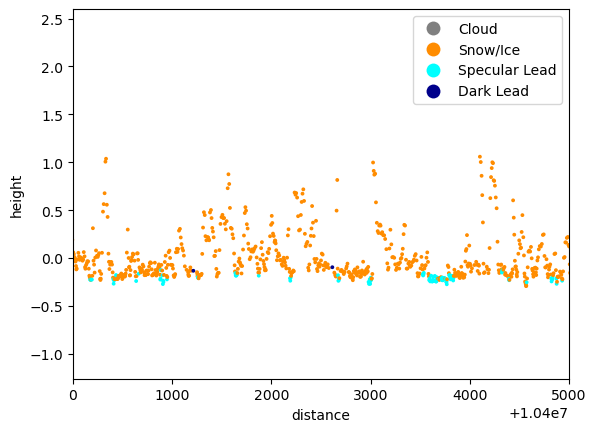

In [23]:
m = df.plot.scatter(x="distance", y="height", c="surface_type", 
                    s=3, cmap=surface_type_cmap, norm=surface_type_norm,
                    colorbar=False, #)
                    xlim=(1.04e7,1.0405e7))

handles = [Line2D([0], [0], linestyle='none', marker='o',
                  markerfacecolor=col, markeredgecolor='none',
                  markersize=10, label=sfc) for sfc, col in zip(surface, colors)]
m.legend(handles=handles)

## Plot ICESat-2 Tracks

It is always helpful to see where the data are located.  We plot GT1R track on a map, with the `Polygon` used in `search_data`.  This time we use latitude and longitude directly from the `DataTree` object.

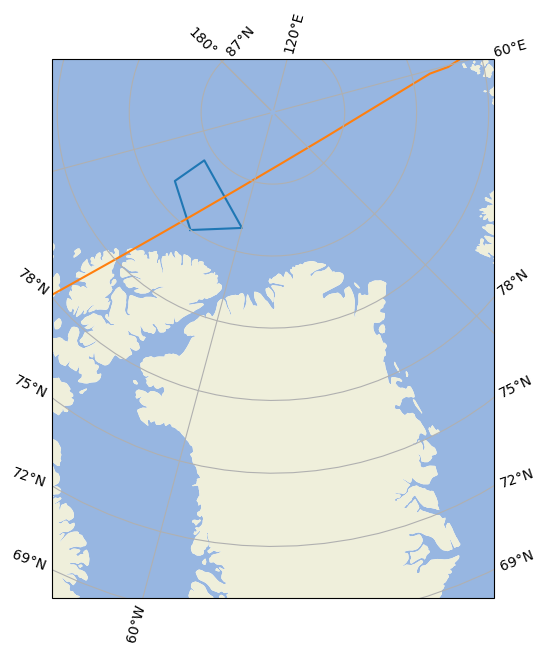

In [31]:
# Define NSIDC WGS84 North Polar Stereographic projection
map_projection = ccrs.Stereographic(
    central_latitude=90., 
    central_longitude=-45,
    true_scale_latitude=70.,
)
extent = [-1000000., 1000000., -2200000., 240000.]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=map_projection)

ax.set_extent(extent, map_projection)

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Plot polygon
ax.plot(lonp, latp, transform=ccrs.PlateCarree())

ax.plot(
    dt["gt1r"]["sea_ice_segments"]["longitude"][::100],
    dt["gt1r"]["sea_ice_segments"]["latitude"][::100],
    transform=ccrs.PlateCarree(),
)
ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)